<a href="https://colab.research.google.com/github/ThomKirwanEvans/VAE-Text-Generation/blob/master/text_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%tensorflow_version 1.x
from keras.layers import Bidirectional, Dense, Embedding, Input, Lambda, LSTM, RepeatVector, TimeDistributed, Layer, Activation, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.layers.advanced_activations import ELU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from scipy import spatial
import tensorflow as tf
import pandas as pd
import numpy as np
import codecs
import csv
import os
import tensorflow_addons as tfa
import tensorflow_hub as hub
import random
print('TF Version:',tf.__version__)

Using TensorFlow backend.


TF Version: 2.2.0


In [ ]:
# Get data and embeddings
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# quora questions csv
file_id = '10ofgOry0gPf62_6DHPAoQOohpCgbJAJJ'
destination = '/content/quora_train.csv'
if not os.path.exists(destination):
  print('Downloading Quora questions')
  download_file_from_google_drive(file_id, destination)
# quora questions text
file_id = '1O-e67fwHCeGvUn-QsrwgadtaEAV8nwLP'
destination = '/content/quora_train.txt'
if not os.path.exists(destination):
  print('Downloading Quora questions')
  download_file_from_google_drive(file_id, destination)
# quora + lyrics
file_id = '1UC8o_uk7QEuMHiJiOc-t1alYzbpUuBwz'
destination = '/content/quora_lyrics.txt'
if not os.path.exists(destination):
  print('Downloading quora + lyrics')
  download_file_from_google_drive(file_id, destination)
# lyrics only
file_id = '1rsXc0QSCmdsSxy-symKy3u05NL0ffXj8'
destination = '/content/lyrics.txt'
if not os.path.exists(destination):
  print('Downloading Kaggle lyrics')
  download_file_from_google_drive(file_id, destination)
  
print('Done')

Done


### Directories and text loading
Initially we will set the main directories and some variables regarding the characteristics of our texts.
We set the maximum sequence length to 15, the maximun number of words in our vocabulary to 12000 and we will use 50-dimensional embeddings. Finally we load our texts from a csv. The text file is the train file of the Quora Kaggle challenge containing around 808000 sentences.

In [ ]:
LOAD = True
DOWNLOAD_MODEL = 'GLOVE_QUORA'
BASE_DIR = '/content/'
TRAIN_FILE = 'quora_train.csv'#'train_micro.csv'
#TRAIN_FILE = 'lyrics.txt'
TRAIN_DATA_FILE = BASE_DIR + TRAIN_FILE
VALIDATION_SPLIT = 0.01
MAX_SEQUENCE_LENGTH = 15
MAX_NB_WORDS = 12000
embedding_model = 'GLOVE50'



if embedding_model == 'GLOVE50':
  EMBEDDING_DIM = 50
  GLOVE_EMBEDDING = BASE_DIR + 'glove.6B.50d.txt'
  EMBED = 'GLOVE'
  if not os.path.exists('/content/glove.6b.zip'):
    print('Downloading GLOVE embeddings')
    #url = 'http://nlp.stanford.edu/data/glove.6B.zip'
    #r = requests.get(url)
    #with open('/content/glove.6b.zip', 'wb') as f:
    #    f.write(r.content)
    #import zipfile
    #with zipfile.ZipFile('/content/glove.6b.zip', 'r') as zip_ref:
    #    zip_ref.extractall('/content/')

    file_id = '1aROAqwsrEqRDE7Yk0a2lcrNrflDS1Akc'
    destination = '/content/glove.6B.50d.txt'
    if not os.path.exists(destination):
      print('Downloading Kaggle lyrics')
      download_file_from_google_drive(file_id, destination)

    print('GLOVE ready')
elif embedding_model == 'SWIVEL':
  embed = hub.load("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1")
  EMBED = 'HUB'
  EMBEDDING_DIM = embed(['test']).numpy().size
elif embedding_model == 'USE':
  embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
  EMBED = 'HUB'
  EMBEDDING_DIM = embed(['test']).numpy().size


if TRAIN_FILE == 'quora_train.csv':
  texts = [] 
  with open(TRAIN_DATA_FILE, 'r', encoding='utf-8') as f:
      reader = csv.reader(f, delimiter=',')
      header = next(reader)
      for values in reader:
          texts.append(values[3])
          texts.append(values[4])

else:
  with open(TRAIN_DATA_FILE,'r',encoding='utf-8') as infile:
    texts = infile.readlines()
print('Found %s texts' % len(texts))
  

# everyday I'm shuffling

random.shuffle(texts)

GLOVE ready
Found 808580 texts


In [ ]:
# test hub model instead

#USE = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
#SWIVEL = hub.load("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1")
#W2V = hub.load("https://tfhub.dev/google/Wiki-words-250/2")
#NNLM = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
#NNLM50 = hub.Module("https://tfhub.dev/google/random-nnlm-en-dim50/1")

#print(SWIVEL(['test']).numpy())

### Text Preprocessing
To preprocess the text we will use the tokenizer and the text_to_sequences function from Keras


In [ ]:
tokenizer = Tokenizer(MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index #the dict values start from 1 so this is fine with zeropadding
index2word = {v: k for k, v in word_index.items()}
print('Found %s unique tokens' % len(word_index))
sequences = tokenizer.texts_to_sequences(texts)
data_1 = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Initial shape of data tensor:', data_1.shape)
NB_WORDS = (min(tokenizer.num_words, len(word_index)) + 1 ) #+1 for zero padding
print('Found',NB_WORDS,'words')



# trim data to the nearest 100 samples
n_texts = len(texts)
n_trim = int(np.floor(n_texts/100)*100)
print('Trimming to',n_trim)
data_1 = data_1[:n_trim]


n_texts = len(data_1)
val_pct = VALIDATION_SPLIT
val_num = int(np.ceil(n_texts*val_pct/100)*100)
val_from = n_texts - val_num


data_1_val = data_1[val_from:]
data_1 = data_1[:val_from] 
print('Shape of train tensor:', data_1.shape)
print('Shape of val tensor:', data_1_val.shape)
n_train = data_1.shape[0]



Found 95596 unique tokens
Initial shape of data tensor: (808580, 15)
Found 12001 words
Trimming to 808500
Shape of train tensor: (800400, 15)
Shape of val tensor: (8100, 15)


In [ ]:
# check that data doesn't just have a load of nulls
print(data_1)
print(texts)
print(tokenizer.texts_to_sequences(texts))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(array([4.95778e+05, 2.60437e+05, 4.68380e+04, 3.86700e+03, 1.29400e+03,
        2.91000e+02, 2.70000e+01, 1.20000e+01, 6.00000e+00, 6.00000e+00,
        5.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.60000e+01]),
 array([   0.  ,   58.45,  116.9 ,  175.35,  233.8 ,  292.25,  350.7 ,
         409.15,  467.6 ,  526.05,  584.5 ,  642.95,  701.4 ,  759.85,
         818.3 ,  876.75,  935.2 ,  993.65, 1052.1 , 1110.55, 1169.  ]),
 <a list of 20 Patch objects>)

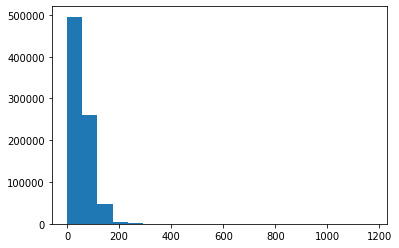

In [ ]:
# Let's check the sequence length
from matplotlib import pyplot as plt
line_len = [len(x) for x in texts]
plt.hist(np.array(line_len),20)

### Sentence generator
In order to reduce the memory requirements we will gradually read our sentences from the csv through Pandas as we feed them to the model

In [ ]:

if TRAIN_FILE == 'quora_train.csv':
  def sent_generator_file(TRAIN_DATA_FILE, chunksize):
      reader = pd.read_csv(TRAIN_DATA_FILE, chunksize=chunksize, iterator=True)
      for df in reader:
          #print(df.shape)
          #df=pd.read_csv(TRAIN_DATA_FILE, iterator=False)
          val3 = df.iloc[:,3:4].values.tolist()
          val4 = df.iloc[:,4:5].values.tolist()
          flat3 = [item for sublist in val3 for item in sublist]
          flat4 = [str(item) for sublist in val4 for item in sublist]
          texts = [] 
          texts.extend(flat3[:])
          texts.extend(flat4[:])
          
          sequences = tokenizer.texts_to_sequences(texts)
          data_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
          yield [data_train, data_train]
else:
  def sent_generator_file(TRAIN_DATA_FILE, chunksize):
      reader = pd.read_csv(TRAIN_DATA_FILE, chunksize=chunksize, iterator=True, delimiter='\n')
      for df in reader:
          texts = df.values.tolist()
          texts = [x[0] for x in texts]
          sequences = tokenizer.texts_to_sequences(texts)
          data_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
          yield [data_train, data_train]

def sent_generator(data, chunksize):
  start = 0
  end = start+chunksize
  n = data.shape[0]
  while end <= n:
    _data = data[start:end,:]    
    start = end
    end = start+chunksize
    yield[_data,_data]

# the last batch should be the same size as the first, else we'll have errors later
sgen = sent_generator(data_1,100)
count = 0
for d in sgen:
  count += 1
  pass
print(d[0].shape)
print(data_1.shape)



(100, 15)
(800400, 15)


### Word embeddings
We will use pretrained Glove word embeddings as embeddings for our network. We create a matrix with one embedding for every word in our vocabulary and then we will pass this matrix as weights to the keras embedding layer of our model

In [ ]:
if EMBED == 'GLOVE':
  embeddings_index = {}
  f = open(GLOVE_EMBEDDING, encoding='utf8')
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
elif EMBED == 'HUB':
  print('Calculating individual word embeddings - batch to speed up')
  embeddings_index = {}
  embeddings_index['unk'] = embed(['unknown']).numpy()

print('Found %s precached word vectors.' % len(embeddings_index))

glove_embedding_matrix = np.zeros((NB_WORDS, EMBEDDING_DIM))
unknown_count = 0
for word, i in word_index.items():
    if i < NB_WORDS:
        if EMBED == 'GLOVE':
          embedding_vector = embeddings_index.get(word)
        elif EMBED == 'HUB':
          embedding_vector = embed([word]).numpy()
        if embedding_vector is not None:
            # words not found in embedding index will be the word embedding of 'unk'.
            glove_embedding_matrix[i] = embedding_vector
        else:
            glove_embedding_matrix[i] = embeddings_index.get('unk')
            unknown_count += 1
print('Null word embeddings: %d' % np.sum(np.sum(glove_embedding_matrix, axis=1) == 0))
print('Unknown count:',unknown_count)



Found 400000 precached word vectors.
Null word embeddings: 1
Unknown count: 374


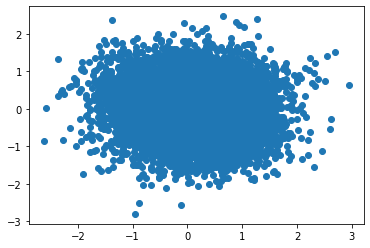

In [ ]:
from matplotlib import pyplot as plt
plt.scatter(glove_embedding_matrix[:,0],glove_embedding_matrix[:,1])

### VAE model
Our model is based on a seq2seq architecture with a bidirectional LSTM encoder and an LSTM decoder and ELU activations.
We feed the latent representation at every timestep as input to the decoder through "RepeatVector(max_len)".
To avoid the one-hot representation of labels we use the "tf.contrib.seq2seq.sequence_loss" that requires as labels only the word indexes (the same that go in input to the embedding matrix) and calculates internally the final softmax (so the model ends with a dense layer with linear activation). Optionally the "sequence_loss" allows to use the sampled softmax which helps when dealing with large vocabularies (for example with a 50k words vocabulary) but in this I didn't use it.
Moreover, due to the pandas iterator that reads the csv both the train size and validation size must be divisible by the batch_size.

In [ ]:
batch_size = 100
max_len = MAX_SEQUENCE_LENGTH
emb_dim = EMBEDDING_DIM
latent_dim = 32
intermediate_dim = 96
epsilon_std = 1.0
num_sampled=500
act = ELU()

#y = Input(batch_shape=(None, max_len, NB_WORDS))
x = Input(batch_shape=(None, max_len))
x_embed = Embedding(NB_WORDS, emb_dim, weights=[glove_embedding_matrix],
                            input_length=max_len, trainable=False)(x)
h = Bidirectional(LSTM(intermediate_dim, return_sequences=False, recurrent_dropout=0.2), merge_mode='concat')(x_embed)
#h = Bidirectional(LSTM(intermediate_dim, return_sequences=False), merge_mode='concat')(h)
h = Dropout(0.2)(h)
h = Dense(intermediate_dim, activation='linear')(h)
h = act(h)
h = Dropout(0.2)(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
repeated_context = RepeatVector(max_len)
decoder_h = LSTM(intermediate_dim, return_sequences=True, recurrent_dropout=0.2)
decoder_mean = TimeDistributed(Dense(NB_WORDS, activation='linear'))#softmax is applied in the seq2seqloss by tf
h_decoded = decoder_h(repeated_context(z))
x_decoded_mean = decoder_mean(h_decoded)


# placeholder loss
def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

#=========================== Necessary only if you want to use Sampled Softmax =======================#
#Sampled softmax
logits = tf.constant(np.random.randn(batch_size, max_len, NB_WORDS), tf.float32)
targets = tf.constant(np.random.randint(NB_WORDS, size=(batch_size, max_len)), tf.int32)
proj_w = tf.constant(np.random.randn(NB_WORDS, NB_WORDS), tf.float32)
proj_b = tf.constant(np.zeros(NB_WORDS), tf.float32)

def _sampled_loss(labels, logits):
    labels = tf.cast(labels, tf.int64)
    labels = tf.reshape(labels, [-1, 1])
    logits = tf.cast(logits, tf.float32)
    return tf.cast(
                    tf.nn.sampled_softmax_loss(
                        proj_w,
                        proj_b,
                        labels,
                        logits,
                        num_sampled=num_sampled,
                        num_classes=NB_WORDS),
                    tf.float32)
softmax_loss_f = _sampled_loss
#====================================================================================================#

# Custom VAE loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)
        self.target_weights = tf.constant(np.ones((batch_size, max_len)), tf.float32)

    def vae_loss(self, x, x_decoded_mean):
        #xent_loss = K.sum(metrics.categorical_crossentropy(x, x_decoded_mean), axis=-1)
        labels = tf.cast(x, tf.int32)
        xent_loss = K.sum(tfa.seq2seq.sequence_loss(x_decoded_mean, labels, 
                                                     weights=self.target_weights,
                                                     average_across_timesteps=False,
                                                     average_across_batch=False), axis=-1)
                                                     #softmax_loss_function=softmax_loss_f), axis=-1)#, uncomment for sampled doftmax
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        print(x.shape, x_decoded_mean.shape)
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # we don't use this output, but it has to have the correct shape:
        return K.ones_like(x)

loss_layer = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, [loss_layer])
opt = Adam(lr=0.01) #SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
vae.compile(optimizer='adam', loss=[zero_loss])
vae.summary()


(None, 15) (100, 15, 12001)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 15, 50)       600050      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 192)          112896      embedding_2[0][0]                
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 192)          0           bidirectional_2[0][0]            
________________________________________________________________

In [ ]:
if len(DOWNLOAD_MODEL)>0:
  print('Downloading model',DOWNLOAD_MODEL)
  if DOWNLOAD_MODEL == 'GLOVE_QUORA':    
    file_id = '1pE1XOueOayigOiatY67ysTx0L_K4PbMnP'

  destination = '/content/models/vae_seq2seq.h5'
  if not os.path.exists('/content/models/'):
    os.mkdir('/content/models/')
  if not os.path.exists(destination):      
    download_file_from_google_drive(file_id, destination)
  else:
    print('Model exists; delete if you want to download')
    1/0
print('Done')

Done


In [ ]:
# load the existing model if there is one
if LOAD and os.path.exists('/content/models/vae_seq2seq.h5'):
  vae.load_weights('/content/models/vae_seq2seq.h5')
  print('Loaded weights')

OSError: ignored

### Model training
We train our model for 100 epochs through keras ".fit_generator". The number of steps per epoch is equal to the number of sentences that we have in the train set (800000) divided by the batch size; the additional /2 is due to the fact that our csv has two sentnces per line so in the end we have to read with our generator only 400000 lines per epoch.
For validation data we pass the same array twice since input and labels of this model are the same. 
If we didn't use the "tf.contrib.seq2seq.sequence_loss" (or another similar function) we would have had to pass as labels the sequence of word one-hot encodings with dimension (batch_size, seq_len, vocab_size) consuming a lot of memory.

In [ ]:
def create_model_checkpoint(dir, model_name):
    filepath = dir + '/' + model_name + ".h5" #-{epoch:02d}-{decoded_mean:.2f}
    directory = os.path.dirname(filepath)
    try:
        os.stat(directory)
    except:
        os.mkdir(directory)
    checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=False)
    return checkpointer

checkpointer = create_model_checkpoint('models', 'vae_seq2seq')

max_sent = 1000
nb_epoch = 100
n_steps = round(n_train/batch_size/2) #we use the first 800000
print(n_steps,'steps per epoch')
vocabulary = []
for counter in range(nb_epoch):
    # everytime we're shuffling
    np.random.shuffle(data_1)
    np.random.shuffle(data_1_val)
    print('-------epoch: ',counter,'--------')
    vae.fit_generator(sent_generator(data_1, batch_size),
                          steps_per_epoch=n_steps, epochs=1, callbacks=[checkpointer],
                          validation_data=(data_1_val, data_1_val))
    
    
    # predict new words
    # build a model to project sentences on the latent space
    encoder = Model(x, z_mean)

    # build a generator that can sample sentences from the learned distribution
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(repeated_context(decoder_input))
    _x_decoded_mean = decoder_mean(_h_decoded)
    _x_decoded_mean = Activation('softmax')(_x_decoded_mean)
    generator = Model(decoder_input, _x_decoded_mean)

    index2word = {v: k for k, v in word_index.items()}
    sent_encoded = encoder.predict(data_1_val[:max_sent,:], batch_size = 16)
    x_test_reconstructed = generator.predict(sent_encoded)
    original_words = []
    predicted_words = []
                                            
    for sent_idx in range(max_sent):
      reconstructed_indexes = np.apply_along_axis(np.argmax, 1, x_test_reconstructed[sent_idx])
      #np.apply_along_axis(np.max, 1, x_test_reconstructed[sent_idx])
      #np.max(np.apply_along_axis(np.max, 1, x_test_reconstructed[sent_idx]))
      word_list = list(np.vectorize(index2word.get)(reconstructed_indexes))
      word_list = ['' if x==None else x for x in word_list]
      original_sent = list(np.vectorize(index2word.get)(data_1_val[sent_idx]))
      original_sent = ['' if x==None else x for x in original_sent]
      original_words += original_sent
      predicted_words += word_list
    ow = len(set(original_words))
    pw = len(set(predicted_words))
    tw = len(original_words)
    vocabulary = set(list(vocabulary) + list(set(predicted_words)))
    vw = len(vocabulary)
    print('Predicting',pw,'/',ow,'unique words in validation set (',vw,'word vocabulary )')
    print('Target sentence:',' '.join(original_sent))
    print('Predicted sentence:',' '.join(word_list))

vae.save('models/vae_finished.h5')

### Project and sample sentences from the latent space
Now we build an encoder model model that takes a sentence and projects it on the latent space and a decoder model that goes from the latent space back to the text representation

In [ ]:
# build a model to project sentences on the latent space
encoder = Model(x, z_mean)

# build a generator that can sample sentences from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(repeated_context(decoder_input))
_x_decoded_mean = decoder_mean(_h_decoded)
_x_decoded_mean = Activation('softmax')(_x_decoded_mean)
generator = Model(decoder_input, _x_decoded_mean)

### Test on validation sentences

In [ ]:
max_sent = 1500
index2word = {v: k for k, v in word_index.items()}
sent_encoded = encoder.predict(data_1_val[:max_sent,:], batch_size = 16)
x_test_reconstructed = generator.predict(sent_encoded)
original_words = []
predicted_words = []
                                         
for sent_idx in range(10):
  reconstructed_indexes = np.apply_along_axis(np.argmax, 1, x_test_reconstructed[sent_idx])
  #np.apply_along_axis(np.max, 1, x_test_reconstructed[sent_idx])
  #np.max(np.apply_along_axis(np.max, 1, x_test_reconstructed[sent_idx]))
  word_list = list(np.vectorize(index2word.get)(reconstructed_indexes))
  word_list = ['' if x==None else x for x in word_list]
  print('Word list:',' '.join(word_list))
  original_sent = list(np.vectorize(index2word.get)(data_1_val[sent_idx]))
  original_sent = ['' if x==None else x for x in original_sent]
  print('Original sentence:',' '.join(original_sent))

  original_words += original_sent
  predicted_words += word_list
ow = len(set(original_words))
pw = len(set(predicted_words))
print('Predicting',pw,'/',ow,'unique words')

In [ ]:
print(reconstructed_indexes)

### Sentence processing and interpolation

In [ ]:
# function to parse a sentence
def sent_parse(sentence, mat_shape):
    sequence = tokenizer.texts_to_sequences(sentence)
    padded_sent = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
    return padded_sent#[padded_sent, sent_one_hot]

# input: encoded sentence vector
# output: encoded sentence vector in dataset with highest cosine similarity
def find_similar_encoding(sent_vect):
    all_cosine = []
    for sent in sent_encoded:
        result = 1 - spatial.distance.cosine(sent_vect, sent)
        all_cosine.append(result)
    data_array = np.array(all_cosine)
    maximum = data_array.argsort()[-3:][::-1][1]
    new_vec = sent_encoded[maximum]
    return new_vec

# input: two points, integer n
# output: n equidistant points on the line between the input points (inclusive)
def shortest_homology(point_one, point_two, num):
    dist_vec = point_two - point_one
    sample = np.linspace(0, 1, num, endpoint = True)
    hom_sample = []
    for s in sample:
        hom_sample.append(point_one + s * dist_vec)
    return hom_sample

# input: original dimension sentence vector
# output: sentence text
def print_latent_sentence(sent_vect):
    sent_vect = np.reshape(sent_vect,[1,latent_dim])
    sent_reconstructed = generator.predict(sent_vect)
    sent_reconstructed = np.reshape(sent_reconstructed,[max_len,NB_WORDS])
    reconstructed_indexes = np.apply_along_axis(np.argmax, 1, sent_reconstructed)
    np.apply_along_axis(np.max, 1, x_test_reconstructed[sent_idx])
    np.max(np.apply_along_axis(np.max, 1, x_test_reconstructed[sent_idx]))
    word_list = list(np.vectorize(index2word.get)(reconstructed_indexes))
    w_list = [w for w in word_list if w]
    print(' '.join(w_list))
    #print(word_list)
        
def new_sents_interp(sent1, sent2, n):
    tok_sent1 = sent_parse(sent1, [15])
    tok_sent2 = sent_parse(sent2, [15])
    enc_sent1 = encoder.predict(tok_sent1, batch_size = 16)
    enc_sent2 = encoder.predict(tok_sent2, batch_size = 16)
    test_hom = shortest_homology(enc_sent1, enc_sent2, n)
    for point in test_hom:
        print_latent_sentence(point)

### Example
Now we can try to parse two sentences and interpolate between them generating new sentences

In [ ]:
sentence1=['where can i find a book on machine learning']
print('From:',sentence1)
mysent = sent_parse(sentence1, [15])
mysent_encoded = encoder.predict(mysent, batch_size = 16)
print_latent_sentence(mysent_encoded)
print_latent_sentence(find_similar_encoding(mysent_encoded))

sentence2=['how can i become a successful entrepreneur']
mysent2 = sent_parse(sentence2, [15])
mysent_encoded2 = encoder.predict(mysent2, batch_size = 16)
print_latent_sentence(mysent_encoded2)
print_latent_sentence(find_similar_encoding(mysent_encoded2))
print('-----------------')

new_sents_interp(sentence1, sentence2, 6)
print('To:',sentence2)

### Results
After training with these parameters for 100 epochs I got these results from interpolating between these two sentences:

sentence1=['where can i find a book on machine learning']
sentence2=['how can i become a successful entrepreneur']

Generated sentences:
- ------------------------------------------- -
-  where can i find a book on machine learning
-  where can i find a a machine book
-  how can i write a a machine book
-  how can i become a successful architect
-  how can i become a successful architect
-  how can i become a successful entrepreneur
- ------------------------------------------- -

As we can see the results are not yet completely satisfying because not all the sentences are grammatically correct and in the interpolation the same sentence has been generated multiple times but anyway the model, even in this preliminary version seems to start working.
There are certainly many improvements that could be done like:
-  removing all the sentences longer than 15 instead of just truncating them
-  introduce the equivalent of word dropout used in the original paper for this decoder architecture 
-  parameter tuning (this model trains in few hours on a GTX950M with 2GB memory so it's definitely possible to try larger nets)
-  Using word embeddings with higher dimensionality
-  train on a more general dataset (Quora sentences are all questions)

Stay tuned for future refinings of the model!